# Lab 5 continue

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, discriminant_analysis, metrics
from scipy import optimize
import seaborn as sns

In [2]:
def plotLine(ax, xRange, w, x0, label, color='grey', linestyle='-', alpha=1.):
    """ Plot a (separating) line given the normal vector (weights) and point of intercept """
    if type(x0) == int or type(x0) == float or type(x0) == np.float64:
        x0 = [0, -x0 / w[1]]
    yy = -(w[0] / w[1]) * (xRange - x0[0]) + x0[1]
    ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    
def plotSvm(X, y, support=None, w=None, intercept=0., label='Data', separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    if ax is None:
        fig, ax = plt.subplots(1)
    
    im = ax.scatter(X[:,0], X[:,1], c=y, cmap=cmap, alpha=0.5, label=label)
    if support is not None:
        ax.scatter(support[:,0], support[:,1], label='Support', s=80, facecolors='none', 
                   edgecolors='y', color='y')
        print("Number of support vectors = %d" % (len(support)))
    if w is not None:
        xx = np.array(bound[0])
        plotLine(ax, xx, w, intercept, separatorLabel)
        # Захын зайг дүрслэх
        if support is not None:
            signedDist = np.matmul(support, w)
            margin = np.max(signedDist) - np.min(signedDist) * np.sqrt(np.dot(w, w))
            supportMaxNeg = support[np.argmin(signedDist)]
            plotLine(ax, xx, w, supportMaxNeg, 'Margin -', linestyle='-.', alpha=0.8)
            supportMaxPos = support[np.argmax(signedDist)]
            plotLine(ax, xx, w, supportMaxPos, 'Margin +', linestyle='--', alpha=0.8)
            ax.set_title('Margin = %.3f' % (margin))
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])
    cb = plt.colorbar(im, ax=ax)
    loc = np.arange(-1,1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels(['-1','1'])

In [3]:
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values');

In [4]:
def generateBatchXor(n, mu=0.5, sigma=0.5):
    """ Four gaussian clouds in a Xor fashion """
    X = np.random.normal(mu, sigma, (n, 2))
    yB0 = np.random.uniform(0, 1, n) > 0.5
    yB1 = np.random.uniform(0, 1, n) > 0.5
    y0 = 2. * yB0 - 1
    y1 = 2. * yB1 - 1
    X[:,0] *= y0
    X[:,1] *= y1
    X -= X.mean(axis=0)
    return X, y0*y1

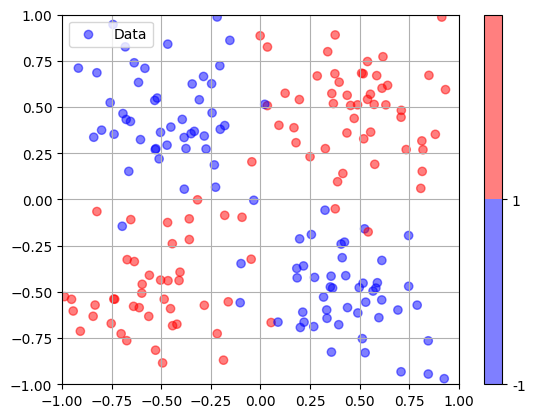

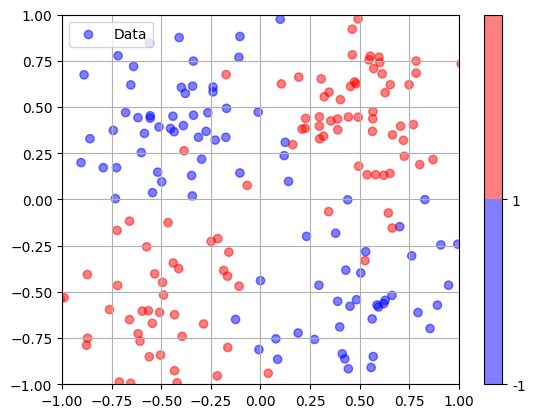

In [5]:
colors = ['blue','red']
cmap = pltcolors.ListedColormap(colors)
nFeatures = 2
N = 100
xTrain, yTrain = generateBatchXor(2*N, sigma=0.25)
plotSvm(xTrain, yTrain)
xTest, yTest = generateBatchXor(2*N, sigma=0.25)
plotSvm(xTest, yTest)

## Kernel trick танилцуулга

Регресс гэх мэт шугаман тусгаарлагчийг ашиглах үед шугаман бус функцийг шийдвэрлэх уламжлалт арга бол анхны шинж чанаруудын зэрэгт болон үржвэрүүдийг ашиглан функцын орон зайг өргөжүүлэх явдал юм.

Шугаман арганд хязгаарлалт бий. Жишээлбэл, XOR асуудлыг зөв шийдвэрийн муж гаргаагүй байна.

SVM нь "Kernel trick" гэгддэг шинэ аргыг ашигласан.

$h(x)$ функцийг ашиглан $x$-д хувиргалтыг хэрэгжүүлцгээе.

Лагранж (Вольф) давхар (хос) асуудал дараах байдалтай байна. 
$$\begin{align}
\mathcal{L}_d (\alpha)
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k y_i y_k h(x_i)^T h(x_k) \\
&= \sum_{i=0}^n \alpha_i - \frac 12 \sum_{i=0}^n \sum_{k=0}^n \alpha_i \alpha_k \langle y_i h(x_i), y_k  h(x_k) \rangle \\
\end{align}$$

__Subject to $\forall i\in 1..n$:__
- $0 \le \alpha_i \le C$
- $\sum_{i=0}^n \alpha_i y_i = 0$

$ w = \sum_{i=0}^n \alpha_i y_i h(x_i)$ тул таамаглах функц байна:
$$ f(x) = sign(w^T h(x) + b) = sign \left(\sum_{i=0}^n \alpha_i y_i \langle h(x_i), h(x) \rangle \right) $$

Энэ таамаглалыг дэмжих вектор болох $\alpha_i > 0$-д тооцоолох шаардлагатай.

Тохиромжтой болон таамаглал хоёулаа Kernel функц гэгддэг $K(x, x') = \langle h(x), h(x') \rangle$ дотоод бүтээгдэхүүн дээр суурилдаг. Энэ функц нь тэгш хэмтэй, хагас тодорхой байна.

Gaussian Radial Basis Function (RBF) : $K(x, x') = exp(- \gamma \Vert x - x' \Vert^2 )$

### G-RBF Kernel-тэй SVM-ийн хэрэгжүүлцгээе

Шугаман SVM хэрэгжүүлэлт дээр хийсэн өөрчлөлтүүд нь _"# --->"_-ээр эхэлж, _"# <---"_ -ээр төгссөн блокуудад хавсаргасан болно.

In [6]:
class KernelSvmClassifier:
    
    def __init__(self, C, kernel):
        self.C = C                               
        self.kernel = kernel          # <---
        self.alpha = None
        self.supportVectors = None
    
    def fit(self, X, y):
        N = len(y)
        # --->
        # h(x) y -ийн Gram matrix 
        hXX = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  self.kernel(x1, x2), 1, X),
                                  1, X)   
        yp = y.reshape(-1, 1)
        GramHXy = hXX * np.matmul(yp, yp.T) 
        # <---

        # Lagrange давхар асуудал
        def Ld0(G, alpha):
            return alpha.sum() - 0.5 * alpha.dot(alpha.dot(G))

        # алфа дээрх Лд-ийн хэсэгчилсэн уламжлал
        def Ld0dAlpha(G, alpha):
            return np.ones_like(alpha) - alpha.dot(G)

        # Хэлбэрийн альфа дээрх хязгаарлалт :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0
        A = np.vstack((-np.eye(N), np.eye(N)))             # <---
        b = np.hstack((np.zeros(N), self.C * np.ones(N)))  # <---
        constraints = ({'type': 'eq',   'fun': lambda a: np.dot(a, y),     'jac': lambda a: y},
                       {'type': 'ineq', 'fun': lambda a: b - np.dot(A, a), 'jac': lambda a: -A})

        # Эсрэгээр нь багасгах замаар дээд зэргээр нэмэгдүүлэх
        optRes = optimize.minimize(fun=lambda a: -Ld0(GramHXy, a),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda a: -Ld0dAlpha(GramHXy, a), 
                                   constraints=constraints)
        self.alpha = optRes.x
        # --->
        epsilon = 1e-8
        supportIndices = self.alpha > epsilon
        self.supportVectors = X[supportIndices]
        self.supportAlphaY = y[supportIndices] * self.alpha[supportIndices]
        # <---
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        # --->
        def predict1(x):
            x1 = np.apply_along_axis(lambda s: self.kernel(s, x), 1, self.supportVectors)
            x2 = x1 * self.supportAlphaY
            return np.sum(x2)
        
        d = np.apply_along_axis(predict1, 1, X)
        return 2 * (d > 0) - 1
        # <---

In [7]:
def GRBF(x1, x2):
    diff = x1 - x2
    return np.exp(-np.dot(diff, diff) * len(x1) / 2)

# Даалгавар нэмэлт 2 Kernel хэрэгжүүлэх аргын кодыг бичиж туршин үр дүнг харьцуулах

model30 = KernelSvmClassifier(C=5, kernel=GRBF)
model30.fit(xTrain, yTrain)

Number of support vectors = 43


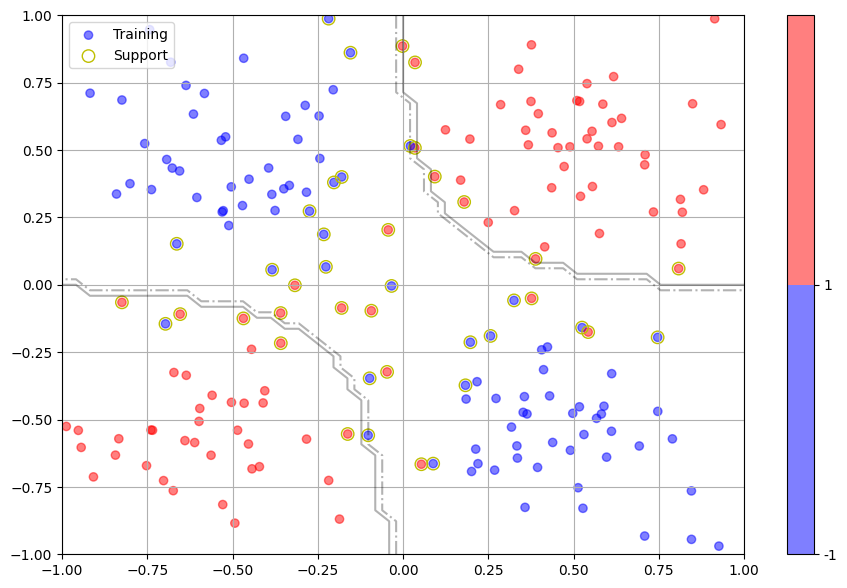

In [8]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain, yTrain, support=model30.supportVectors, label='Training', ax=ax)

# Тооцоолол, шийдвэрийн хил хязгаар
xx = np.linspace(-1, 1, 50)
X0, X1 = np.meshgrid(xx, xx)
xy = np.vstack([X0.ravel(), X1.ravel()]).T
Y30 = model30.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y30, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-']);

## Scikit Learn SVM with Radial basis kernel

In [9]:
model31 = svm.SVC(kernel='rbf', C=10, gamma=1/2, shrinking=False)
model31.fit(xTrain, yTrain)

SVC(C=10, gamma=0.5, shrinking=False)

Number of support vectors = 47


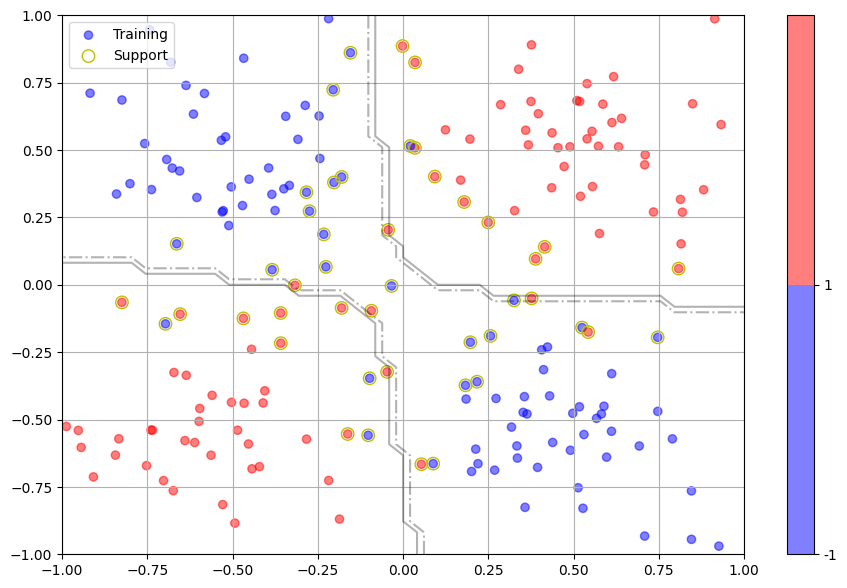

In [10]:
fig, ax = plt.subplots(1, figsize=(11, 7))
plotSvm(xTrain, yTrain, support=model31.support_vectors_, label='Training', ax=ax)

# Тооцоолол, шийдвэрийн хил хязгаар
Y31 = model31.predict(xy).reshape(X0.shape)
ax.contour(X0, X1, Y31, colors='k', levels=[-1, 0], alpha=0.3, linestyles=['-.', '-']);

### SVM with RBF performance on XOR

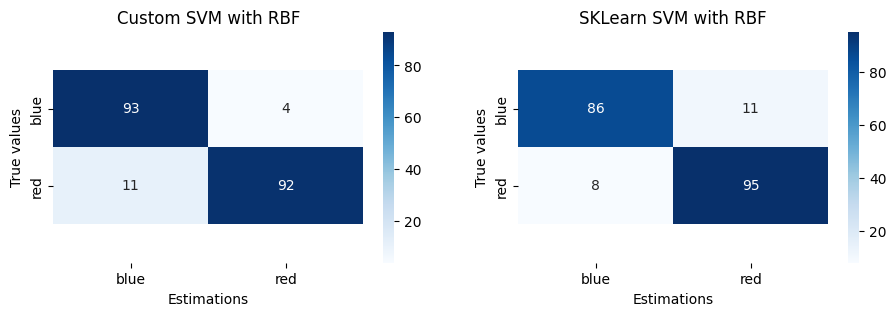

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(11, 3))
for model, ax, title in zip([model30, model31], axes, ["Custom SVM with RBF", "SKLearn SVM with RBF"]):
    yEst3 = model.predict(xTest)
    plotConfusionMatrix(yTest, yEst3, colors, title, ax=ax)

Хоёр загварын таамаглал XOR жишээн дээр бараг таарч байна.

## Дүгнэлт

Шугаман салгах боломжгүй асуудлуудад зориулсан SVM ангилагчийн хүчийг бид харуулсан. 1990-ээд оны сүүлчээс эхлэн SVM нь олон асуудалд зориулсан машин сургалтын алгоритмын бүлийн тэргүүлэгч байсан. Энэ байдал 2010 оноос хойш бага зэрэг өөрчлөгдсөн бөгөөд гүнзгийрүүлсэн сургалт нь зарим ангиллын бодлогод илүү сайн гүйцэтгэлийг харуулсан. Гэсэн хэдий ч SVM нь олон нөхцөл байдалд илүү хүчтэй хэвээр байна. Жишээлбэл, SVM-д зориулсан сургалтын мэдээллийн хэмжээ нь гүнзгий суралцахад шаардагдах хэмжээнээс бага байна.

### Эндээс хаашаа явах вэ

- Multiclass classifier using Neural Nets in Keras ([HTML](ClassificationMulti2Features-Keras.html) / [Jupyter](ClassificationMulti2Features-Keras.ipynb))
- Multiclass classifier using Decision Trees ([HTML](ClassificationMulti2Features-Tree.html) / [Jupyter](ClassificationMulti2Features-Tree.ipynb))
- Bivariate continuous function approximation with Linear Regression ([HTML](ClassificationContinuous2Features.html) / [Jupyter](ClassificationContinuous2Features.ipynb))
- Bivariate continuous function approximation with k Nearest Neighbors ([HTML](ClassificationContinuous2Features-KNN.html) / [Jupyter](ClassificationContinuous2Features-KNN.ipynb))

# Даалгавар
Нэмэлт 2 Kernel хэрэгжүүлэх аргын кодыг бичиж туршин үр дүнг Sklearn-ний үр дүнтэй харьцуулах